In [1]:
import pandas as pd
import numpy as np
import torch
import spacy
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer, util

In [2]:
df = pd.read_csv("kaffee_reviews.csv")
sentences = df.review

In [3]:
model = SentenceTransformer("distiluse-base-multilingual-cased")
nlp = spacy.load("de_core_news_sm")

In [4]:
def noun_tagger(sentence_list, nlp=None):
    nlp = nlp if nlp is not None else spacy.load("de_core_news_sm")
    noun_list = []
    for sentence in sentence_list:
        doc = nlp(sentence)
        noun_list.append([w.text for w in doc if w.tag_ == "NN"]) # or w.tag_ == "NNP"])
    return noun_list

embeddings = model.encode(sentences, convert_to_tensor=True)
token_lists = noun_tagger(sentences, nlp)

In [31]:
cos_sim = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()
cos_dist = 1 - np.around(cos_sim, 5)
dist = torch.cdist(embeddings, embeddings, p=2, compute_mode="donot_use_mm_for_euclid_dist").cpu().numpy()

embeddings_norm = preprocessing.normalize(embeddings.cpu().numpy())

metric = ["cosine", "euclidean", "precomputed"]

In [30]:
#embeddings.cpu().numpy()
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.4, min_samples=5, metric=metric[2]).fit(cos_dist)

labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
for i in range(n_clusters_):
    print(i, len(np.where(labels == i)[0]))
n_noise_ = list(labels).count(-1)

print("n_clusters: %d" % n_clusters_, "n_noise %d" % n_noise_)

0 385
1 10
n_clusters: 2 n_noise 69


In [70]:
from sklearn.cluster import OPTICS
clustering = OPTICS(xi=0.01, min_samples=3, metric=metric[2]).fit(cos_dist)

labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
for i in range(n_clusters_):
    print(i, len(np.where(labels == i)[0]))
n_noise_ = list(labels).count(-1)

print("n_clusters: %d" % n_clusters_, "n_noise %d" % n_noise_)

0 7
1 4
2 3
3 4
4 12
5 7
6 7
7 4
8 4
9 9
10 5
11 7
12 3
13 4
14 6
15 5
16 12
n_clusters: 17 n_noise 361


In [8]:
keywords, count = np.unique(np.concatenate(token_lists), return_counts=True)

In [57]:
# create centroids from most commen keywords, then cos_sim -> softmax to get likelihood
from scipy.special import softmax
n_clusters = len(np.where(count >= 10)[0])
n_clusters = 10
centroid_keywords = keywords[np.argsort(count)[::-1]][:n_clusters]
centroids = model.encode(centroid_keywords, convert_to_tensor=True)

cos_sim_centroids = util.pytorch_cos_sim(embeddings, centroids).cpu().numpy()

cos_sim_centroids_ = cos_sim_centroids.clip(min=0)*5
likelihood = softmax(cos_sim_centroids_, axis=1)
print(likelihood[1]*100)
print(cos_sim_centroids[1])
#np.sort([np.sort(likelihood[i])[::-1][0] for i in range(len(likelihood))])[::-1][:5]

[27.953075   5.9485545  3.2349072  6.6937275 12.360534   3.2349072
  5.42159    3.2349072 25.43567    6.482114 ]
[ 0.4313054   0.12182959 -0.00461774  0.14543414  0.26810172 -0.02713609
  0.10327779 -0.01409695  0.41243047  0.13900931]


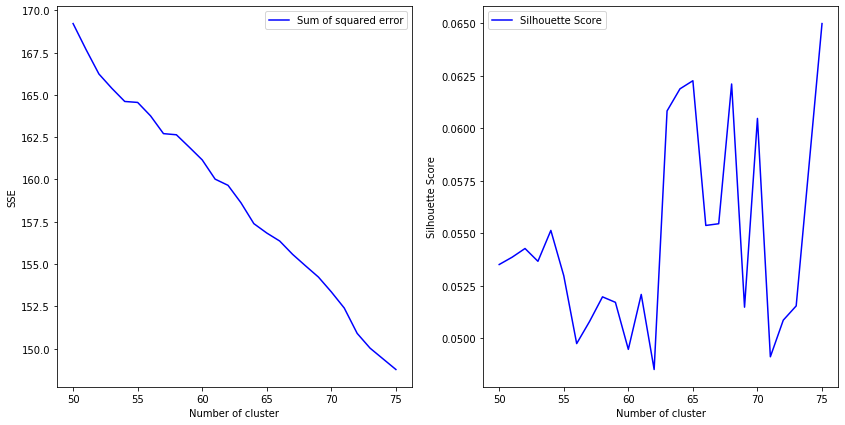

In [114]:
range_n_clusters = np.linspace(50, 75, 25, endpoint=True, dtype=int)
elbow = []
ss = []
for n_clusters in range_n_clusters:
   #iterating through cluster sizes
   clusterer = KMeans(n_clusters = n_clusters, random_state=42)
   cluster_labels = clusterer.fit_predict(embeddings_norm)
   #Finding the average silhouette score
   silhouette_avg = silhouette_score(embeddings_norm, cluster_labels)
   ss.append(silhouette_avg)
   # print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
   #Finding the average SSE"
   elbow.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center
fig = plt.figure(figsize=(14,7))
fig.add_subplot(121)
plt.plot(range_n_clusters, elbow,'b-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(range_n_clusters, ss,'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

In [110]:
# GMM
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=20, covariance_type="full")
gmm.fit(embeddings_norm)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=20, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

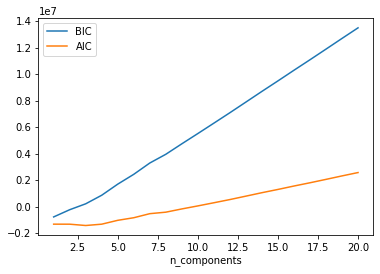

In [112]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(embeddings_norm)
          for n in n_components]

plt.plot(n_components, [m.bic(embeddings_norm) for m in models], label='BIC')
plt.plot(n_components, [m.aic(embeddings_norm) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [142]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=None, distance_threshold=1, linkage="average", affinity=metric[2]).fit(dist)

print(model.n_clusters_)
print(np.unique(model.labels_, return_counts=True))

38
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37], dtype=int64), array([  2, 375,   2,   8,   3,   8,   4,  12,   2,   2,   4,   3,   2,
         1,   2,   8,   2,   1,   3,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   2,   1,   1,   1,   1,   1,   1,   1],
      dtype=int64))
